# 1 - Multi-armed bandits (3 pts.)
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.

Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.  
You will compare the average reward received by:  
>• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;  
    • An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • The UCB policy. 

To do this

1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0 and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

**Question 1. Using the results from the procedure outlined above, plot the average reward obtained with each policy during the 1, 000 steps in a single plot. Comment the differences observed.**

### Notes

A greedy policy is an ε-greedy policy with ε = 0;  
NumPy provides a normal distribution: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html;

Q(a) at timestep t is calculated by:  

![image info](./pictures/qa.png)


![image.info](./pictures/bandit.png)


Previous images are from the *Reinforcement Learning: An Introduction* book, by Sutton and Barto, found in:  
http://incompleteideas.net/sutton/book/the-book-2nd.html

In [34]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [145]:
# Attempt a simple bandit

class Bandit(object):
    
    # Variable initialization
    def __init__(self, n_actions=10, iterations=1000, use_ucb=True, initial_qa=0.0, epsilon=0.0, c=0.0):
        # Set the size of action space
        self.n_actions = n_actions
        
        # Initial Q(a) values
        self.q_actions = np.array([initial_qa for i in np.arange(self.n_actions)])
        
        # Value of picking an action
        self.rewards = np.zeros(self.n_actions)
        
        # Times chosen each action
        self.times_chosen = np.zeros(self.n_actions)
        
        # Number of iteration
        self.max_iterations = iterations
        
        # Number of timesteps
        self.timestep = 0
        
        # Whether we used or not the UCB
        self.is_UCB = use_ucb
        
        # Epsilon for greedy - greedy is 1-
        self.epsilon = epsilon
        
        # Constant C value for UCB
        self.c_value = c
        
        # Total reward
        self.total_reward = 0.0
        
        # Records
        self.records = None
        
    # Return an array of 10 values sampled from a normal distribution
    def __generate_normal__(self, mean=0.0, variance=1.0):
        return np.random.normal(mean, variance, self.n_actions)
    
    # Get Q(a) at timestep n+1
    def __update_action_value__(self, current_q, current_r, times_chosen):
        next_qa = current_q + (current_r - current_q) * (times_chosen ** -1)
        return next_qa
        
    
    # Pick action A at t+1
    def __select_action_ucb__(self):
        next_action = np.argmax([self.q_actions[i] + self.c_value * np.sqrt(np.log(self.timestep) * (self.times_chosen[i]**-1)) 
                                 for i in np.arange(self.n_actions)])
        
        return next_action
    
    def __select_action_epsilon__(self):
        if self.epsilon <= np.random.random():
            known_action = np.argmax(self.q_actions)
            
            # Generate probs for each action
            prob_actions = self.__generate_normal__()
            prob_actions[known_action] = -999
            return np.argmax(prob_actions)
        else:
            return np.argmax(self.q_actions)
        
    def __generate_records__(self, action_picked, reward_received):
        new_df = pd.DataFrame({'Cumulative Reward': self.total_reward,
                               'Picked Action': action_picked,
                               'Reward Received': reward_received}, index=[self.timestep])
        new_df['Average Reward'] = new_df['Cumulative Reward'].values[0] / new_df.index.values[0]
        for action in np.arange(self.n_actions):
            new_df['N(A{})'.format(action)] = self.times_chosen[action]
            new_df['R(A{})'.format(action)] = self.rewards[action]
        
        return new_df
        
            
    def iterate(self):
        # 1 - Initialize Q(a) -> done on class initialization
        # 2 - Generate next rewards from normal distribution
        # 3 - If is UBC, pick each action exactly once first
        # 4 - Pick action based on the UCB or greedy
        # 5 - Get reward for action selected
        # 6 - Update counter of selection for action selected
        # 7 - Get new Q(a) for the selected action
        
        df = pd.DataFrame({})
        
        if self.is_UCB:
            # Pick each action once
            for action in np.arange(self.n_actions):
                self.rewards = self.__generate_normal__()
                self.times_chosen[action] += 1
                self.timestep += 1
                self.__update_action_value__(current_q=self.q_actions[action],
                                             current_r=self.rewards[action],
                                             times_chosen=self.times_chosen[action])
                self.total_reward += self.rewards[action]
                current_record = self.__generate_records__(action_picked=action,
                                                           reward_received=self.rewards[action])
                df = df.append(current_record)
        
        for iteration in np.arange(self.max_iterations):
            # Get the rewards for each action
            self.rewards = self.__generate_normal__()

            # Pick action
            picked_action = 0
            if self.is_UCB:
                picked_action = self.__select_action_ucb__()
            else:
                picked_action = self.__select_action_epsilon__()

            # Update timestep and action counter
            self.times_chosen[picked_action] += 1
            self.timestep += 1

            # Update Q(a)
            self.__update_action_value__(current_q=self.q_actions[picked_action], 
                                         current_r=self.rewards[picked_action], 
                                         times_chosen=self.times_chosen[picked_action])
            
            self.total_reward += self.rewards[picked_action]
            
            current_record = self.__generate_records__(action_picked=picked_action,
                                                       reward_received=self.rewards[picked_action])
            df = df.append(current_record)
        
        self.records = df
        
        return self.records
    
    
    def plot_rewards(self, title=None):
        if self.records is not None:
            
            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

            axs[0].plot(self.records['Cumulative Reward'])
            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Cumulative Reward')
            axs[0].set_title('Cumulative Reward over Iterations')

            axs[1].plot(self.records['Average Reward'])
            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Average Reward')
            axs[1].set_title('Average Reward over Iterations')
            
            fig.suptitle(title, fontsize=14)

            plt.show()

In [153]:
# Instantiate the Bandit class for UCB with C=0 (for test)

bandit = Bandit(iterations=20, use_ucb=True)
bandit.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward,N(A0),R(A0),N(A1),R(A1),N(A2),R(A2),...,N(A5),R(A5),N(A6),R(A6),N(A7),R(A7),N(A8),R(A8),N(A9),R(A9)
1,-0.896308,0,-0.896308,-0.896308,1.0,-0.896308,0.0,-0.126785,0.0,-0.932555,...,0.0,0.182445,0.0,-0.695060,0.0,0.320130,0.0,1.203809,0.0,-2.683642
2,0.252663,1,1.148971,0.126332,1.0,-0.812461,1.0,1.148971,0.0,-0.679468,...,0.0,-2.000501,0.0,-0.159752,0.0,1.347052,0.0,-0.065923,0.0,-0.699259
3,-0.959504,2,-1.212167,-0.319835,1.0,-0.198578,1.0,0.270857,1.0,-1.212167,...,0.0,1.467242,0.0,0.307259,0.0,-0.601038,0.0,-0.272045,0.0,-0.120628
4,-1.828923,3,-0.869420,-0.457231,1.0,-0.574411,1.0,-0.887684,1.0,-0.522554,...,0.0,-1.853643,0.0,-0.338855,0.0,1.990538,0.0,0.485020,0.0,-1.011087
5,-2.778603,4,-0.949679,-0.555721,1.0,1.151454,1.0,1.467596,1.0,2.278417,...,0.0,-0.965835,0.0,0.139442,0.0,-0.065556,0.0,-0.410171,0.0,0.897963
6,-2.210183,5,0.568419,-0.368364,1.0,-0.337706,1.0,0.596477,1.0,0.143117,...,1.0,0.568419,0.0,-0.070088,0.0,-1.825926,0.0,0.046181,0.0,-0.525377
7,-2.796266,6,-0.586083,-0.399467,1.0,0.789388,1.0,-0.608410,1.0,-1.083499,...,1.0,0.184836,1.0,-0.586083,0.0,1.245059,0.0,-0.615690,0.0,0.567501
8,-4.180413,7,-1.384147,-0.522552,1.0,0.355263,1.0,0.099417,1.0,1.635141,...,1.0,0.498823,1.0,0.118807,1.0,-1.384147,0.0,-1.815112,0.0,-0.052642
9,-3.914101,8,0.266312,-0.434900,1.0,0.702135,1.0,-0.018512,1.0,-1.207309,...,1.0,0.963811,1.0,0.071768,1.0,1.471658,1.0,0.266312,0.0,-0.610837
10,-2.008686,9,1.905415,-0.200869,1.0,0.185468,1.0,0.958754,1.0,-0.496506,...,1.0,0.247881,1.0,1.252550,1.0,-1.262076,1.0,-0.325297,1.0,1.905415


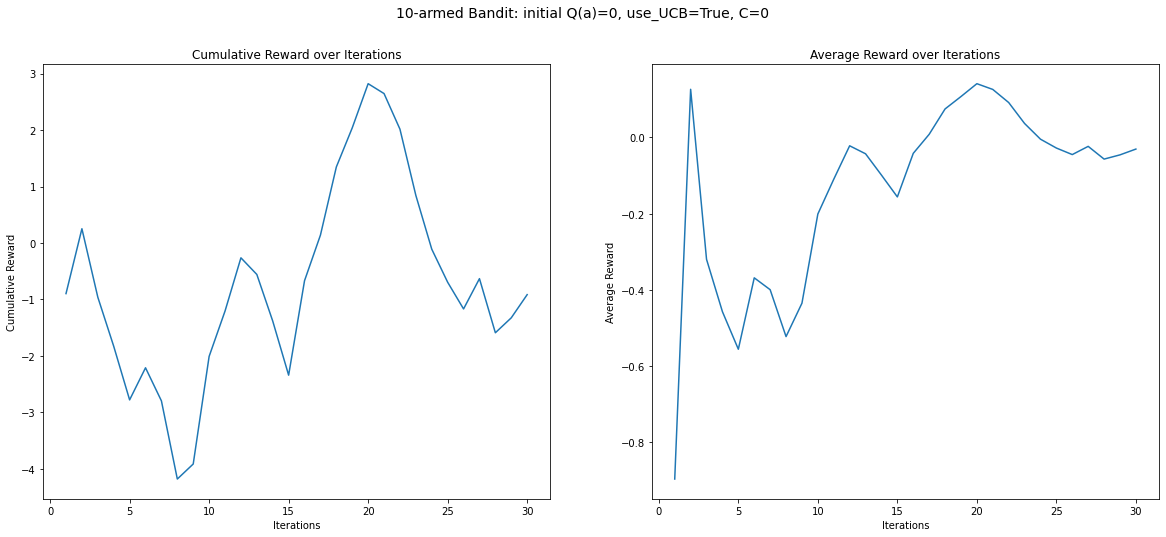

In [154]:
# Plot the Cumulative Reward and Average Reward

bandit.plot_rewards('10-armed Bandit: initial Q(a)=0, use_UCB=True, C=0')

In [155]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
# For this, use_UCB=False, epsilon=0, initial_qa=0

bandit_greedy_q0 = Bandit(iterations=1000, use_ucb=False, epsilon=0, initial_qa=0)
bandit_greedy_q0.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward,N(A0),R(A0),N(A1),R(A1),N(A2),R(A2),...,N(A5),R(A5),N(A6),R(A6),N(A7),R(A7),N(A8),R(A8),N(A9),R(A9)
1,-2.009443,1,-2.009443,-2.009443,0.0,-2.298934,1.0,-2.009443,0.0,-1.807916,...,0.0,1.014573,0.0,-0.402037,0.0,0.050191,0.0,0.893003,0.0,0.878065
2,-1.119792,9,0.889651,-0.559896,0.0,-0.986517,1.0,-0.472534,0.0,0.526931,...,0.0,-2.272681,0.0,0.512348,0.0,-0.699313,0.0,-0.044958,1.0,0.889651
3,-1.717073,1,-0.597281,-0.572358,0.0,-1.953548,2.0,-0.597281,0.0,-0.762745,...,0.0,0.098779,0.0,-0.511805,0.0,-1.948238,0.0,-0.350970,1.0,-0.828439
4,-2.181690,7,-0.464617,-0.545423,0.0,1.437139,2.0,0.069053,0.0,0.853650,...,0.0,-1.168329,0.0,0.385940,1.0,-0.464617,0.0,-0.988682,1.0,-1.070289
5,-3.436732,4,-1.255041,-0.687346,0.0,0.358087,2.0,-0.408664,0.0,0.172733,...,0.0,-1.789055,0.0,0.540079,1.0,-1.657592,0.0,-0.685385,1.0,-0.430807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-27.302029,7,0.042249,-0.027412,0.0,1.302145,105.0,2.691364,107.0,-0.755349,...,118.0,0.015078,127.0,-0.485180,116.0,0.042249,93.0,-1.851785,114.0,-0.964987
997,-26.348498,8,0.953531,-0.026428,0.0,1.106239,105.0,1.211897,107.0,-2.252064,...,118.0,-0.395745,127.0,-0.663555,116.0,-0.535281,94.0,0.953531,114.0,0.874574
998,-25.419547,8,0.928951,-0.025470,0.0,-1.623359,105.0,-0.836302,107.0,0.597122,...,118.0,0.608997,127.0,-1.627059,116.0,-0.242342,95.0,0.928951,114.0,2.211670
999,-25.873613,8,-0.454066,-0.025900,0.0,-1.888123,105.0,0.593752,107.0,-0.820284,...,118.0,0.459223,127.0,-0.251685,116.0,0.548251,96.0,-0.454066,114.0,-0.178596


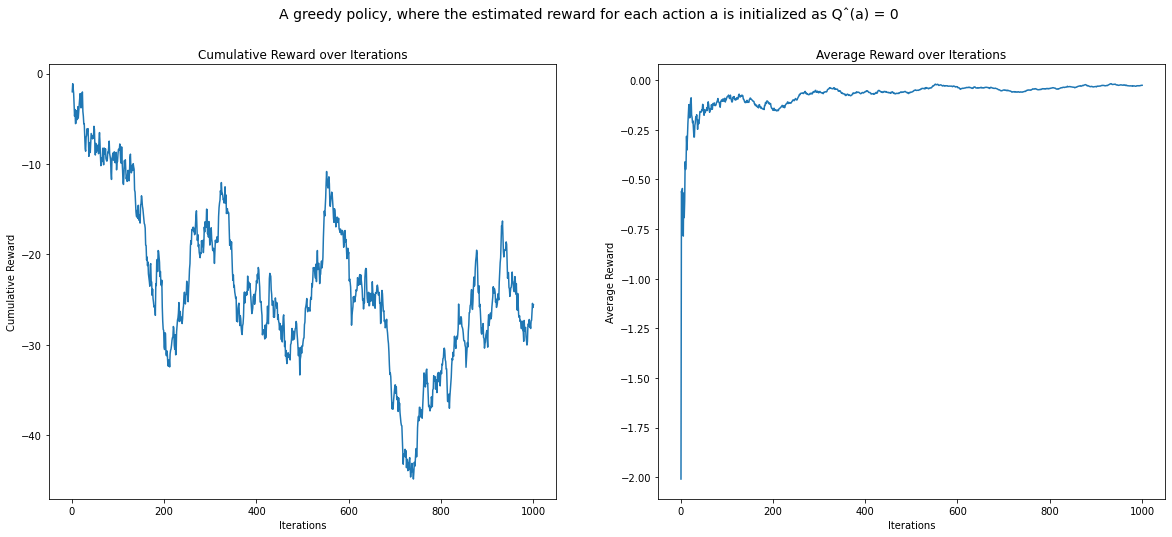

In [156]:
# Plot the Cumulative Reward and Average Reward

bandit_greedy_q0.plot_rewards('A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0')

In [157]:
# A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;
# For this, use_UCB=False, epsilon=0, initial_qa=5

bandit_greedy_q5 = Bandit(iterations=1000, use_ucb=False, epsilon=0, initial_qa=5)
bandit_greedy_q5.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward,N(A0),R(A0),N(A1),R(A1),N(A2),R(A2),...,N(A5),R(A5),N(A6),R(A6),N(A7),R(A7),N(A8),R(A8),N(A9),R(A9)
1,0.384466,3,0.384466,0.384466,0.0,0.046786,0.0,-0.531695,0.0,-0.105447,...,0.0,-1.242128,0.0,-0.334982,0.0,0.068237,0.0,0.306846,0.0,-0.718058
2,2.470596,5,2.086130,1.235298,0.0,-1.105143,0.0,0.069475,0.0,-0.474610,...,1.0,2.086130,0.0,-0.092118,0.0,0.397868,0.0,-0.706348,0.0,1.735109
3,2.195642,9,-0.274954,0.731881,0.0,-1.419245,0.0,-0.776295,0.0,1.053601,...,1.0,-1.292531,0.0,-1.766387,0.0,0.506042,0.0,-1.384092,1.0,-0.274954
4,2.083315,3,-0.112327,0.520829,0.0,2.039063,0.0,0.976683,0.0,0.298151,...,1.0,0.936549,0.0,0.840422,0.0,1.492842,0.0,-0.013556,1.0,0.037227
5,1.768802,8,-0.314514,0.353760,0.0,-0.547725,0.0,0.459517,0.0,0.094215,...,1.0,-0.414152,0.0,1.400326,0.0,-0.871792,1.0,-0.314514,1.0,-0.075798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,126.492813,3,-1.682173,0.127001,0.0,-0.357438,107.0,0.475597,101.0,0.889230,...,113.0,1.375166,137.0,0.444078,109.0,-1.656807,106.0,0.934488,116.0,0.671751
997,126.137244,4,-0.355569,0.126517,0.0,-1.567210,107.0,-0.018450,101.0,0.082469,...,113.0,-0.632374,137.0,-0.863789,109.0,0.274675,106.0,0.671132,116.0,-2.617295
998,126.334781,7,0.197537,0.126588,0.0,-0.858479,107.0,0.874713,101.0,-0.619629,...,113.0,0.756155,137.0,0.206035,110.0,0.197537,106.0,-1.169001,116.0,-0.201383
999,126.878271,3,0.543490,0.127005,0.0,0.487597,107.0,-0.337896,101.0,-0.867636,...,113.0,-1.390973,137.0,-0.936429,110.0,-0.445994,106.0,1.715252,116.0,-0.971977


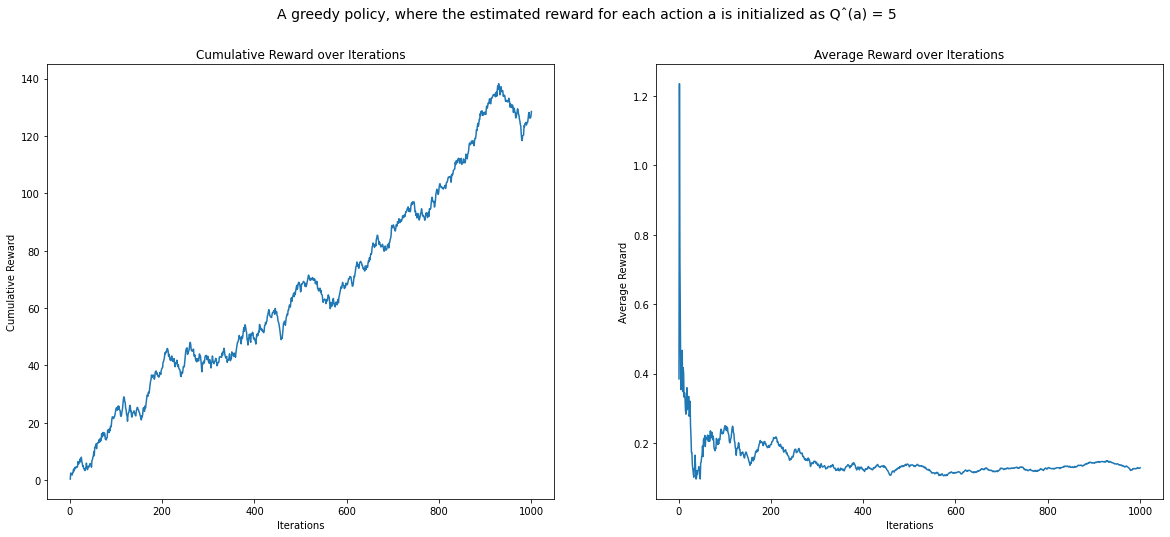

In [158]:
# Plot the Cumulative Reward and Average Reward

bandit_greedy_q5.plot_rewards('A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5')

In [159]:
# An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
# For this, use_UCB=False, epsilon=0.1, initial_qa=0

bandit_epsilon01_q0 = Bandit(iterations=1000, use_ucb=False, epsilon=0.1, initial_qa=0)
bandit_epsilon01_q0.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward,N(A0),R(A0),N(A1),R(A1),N(A2),R(A2),...,N(A5),R(A5),N(A6),R(A6),N(A7),R(A7),N(A8),R(A8),N(A9),R(A9)
1,-0.242765,9,-0.242765,-0.242765,0.0,0.616380,0.0,0.380942,0.0,0.737362,...,0.0,1.937385,0.0,0.271216,0.0,0.879736,0.0,0.304477,1.0,-0.242765
2,0.167162,5,0.409927,0.083581,0.0,0.323574,0.0,-0.340168,0.0,-0.180177,...,1.0,0.409927,0.0,0.828491,0.0,0.721972,0.0,-0.362611,1.0,0.166334
3,-0.047573,8,-0.214735,-0.015858,0.0,1.114272,0.0,1.220016,0.0,-0.017657,...,1.0,-0.059898,0.0,1.153670,0.0,-0.562840,1.0,-0.214735,1.0,-1.798656
4,0.341698,5,0.389271,0.085424,0.0,1.026812,0.0,-0.499001,0.0,0.034471,...,2.0,0.389271,0.0,0.331696,0.0,-0.527857,1.0,-0.046709,1.0,1.057933
5,1.111410,0,0.769712,0.222282,1.0,0.769712,0.0,-0.766622,0.0,1.134286,...,2.0,0.085071,0.0,-1.411660,0.0,-0.596985,1.0,0.236774,1.0,-0.720356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-3.654661,1,-1.699135,-0.003669,105.0,-0.819178,107.0,-1.699135,96.0,-1.668676,...,105.0,0.261275,83.0,-2.348206,106.0,-0.215562,91.0,1.562440,81.0,-0.232984
997,-4.895966,3,-1.241305,-0.004911,105.0,-0.822871,107.0,-0.786807,96.0,1.062482,...,105.0,-0.681352,83.0,-1.696277,106.0,0.284745,91.0,-0.967560,81.0,-0.432113
998,-5.370422,8,-0.474456,-0.005381,105.0,-0.975685,107.0,-2.292605,96.0,1.175719,...,105.0,-0.951060,83.0,-0.323421,106.0,0.291052,92.0,-0.474456,81.0,-0.132208
999,-4.231361,0,1.139061,-0.004236,106.0,1.139061,107.0,0.099335,96.0,1.588140,...,105.0,0.251284,83.0,-2.107462,106.0,-0.334651,92.0,0.535900,81.0,1.005388


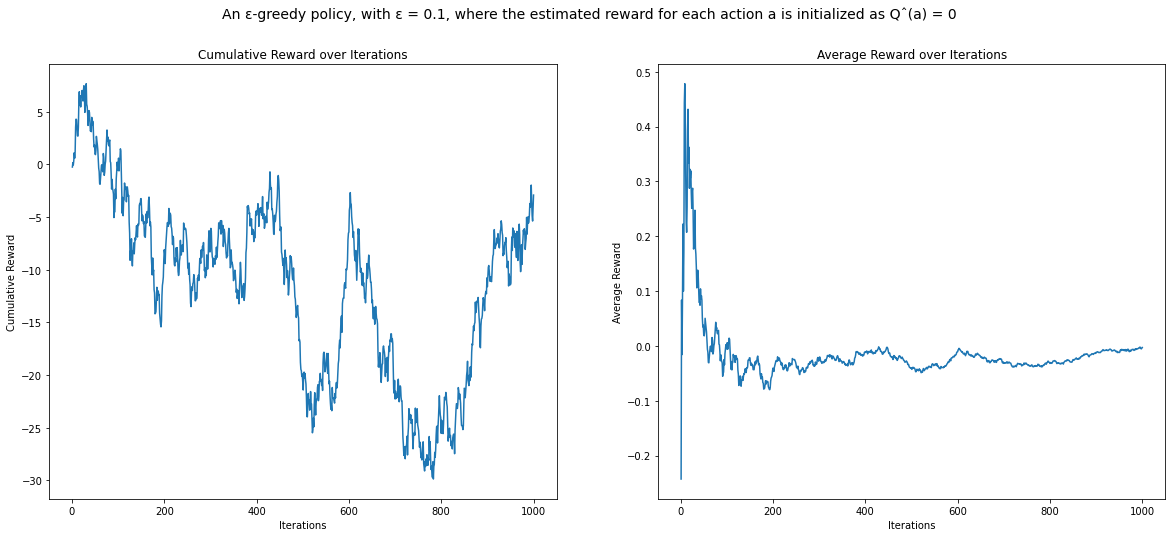

In [160]:
# Plot the Cumulative Reward and Average Reward

bandit_epsilon01_q0.plot_rewards('An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0')

In [161]:
# An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;
# For this, use_UCB=False, epsilon=0.01, initial_qa=0

bandit_epsilon001_q0 = Bandit(iterations=1000, use_ucb=False, epsilon=0.01, initial_qa=0)
bandit_epsilon001_q0.iterate()

,Cumulative Reward,Picked Action,Reward Received,Average Reward,N(A0),R(A0),N(A1),R(A1),N(A2),R(A2),...,N(A5),R(A5),N(A6),R(A6),N(A7),R(A7),N(A8),R(A8),N(A9),R(A9)
1,-0.686042,9,-0.686042,-0.686042,0.0,-0.889065,0.0,-0.343421,0.0,0.514618,...,0.0,1.151020,0.0,0.328548,0.0,-0.856837,0.0,-1.689403,1.0,-0.686042
2,-0.076083,7,0.609960,-0.038041,0.0,1.400545,0.0,-1.061624,0.0,0.232750,...,0.0,-0.380875,0.0,0.249793,1.0,0.609960,0.0,-0.985832,1.0,-0.533885
3,-0.868645,6,-0.792562,-0.289548,0.0,0.678469,0.0,1.000807,0.0,0.793248,...,0.0,0.040350,1.0,-0.792562,1.0,0.073589,0.0,-0.244095,1.0,0.505519
4,-1.312301,9,-0.443656,-0.328075,0.0,1.938300,0.0,-1.036285,0.0,0.453172,...,0.0,1.550161,1.0,1.631373,1.0,-0.912417,0.0,1.149044,2.0,-0.443656
5,-1.366796,3,-0.054495,-0.273359,0.0,0.800365,0.0,-0.939061,0.0,1.611778,...,0.0,0.415371,1.0,0.861130,1.0,0.203398,0.0,0.671424,2.0,0.377865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-3.848296,5,-3.243694,-0.003864,9.0,-1.117650,119.0,0.599594,117.0,-0.913231,...,103.0,-3.243694,105.0,0.626315,113.0,-0.537922,121.0,-2.077880,97.0,2.539198
997,-2.841183,9,1.007114,-0.002850,9.0,0.007251,119.0,-0.593384,117.0,-2.577087,...,103.0,-0.829078,105.0,0.476934,113.0,1.923661,121.0,0.021115,98.0,1.007114
998,-3.078414,6,-0.237232,-0.003085,9.0,0.498856,119.0,1.536438,117.0,0.681817,...,103.0,-0.353857,106.0,-0.237232,113.0,1.772036,121.0,-0.332448,98.0,0.189083
999,-1.040648,3,2.037766,-0.001042,9.0,-1.004964,119.0,1.286694,117.0,1.309158,...,103.0,-0.633955,106.0,-0.580270,113.0,-1.422851,121.0,-0.547638,98.0,-1.462294


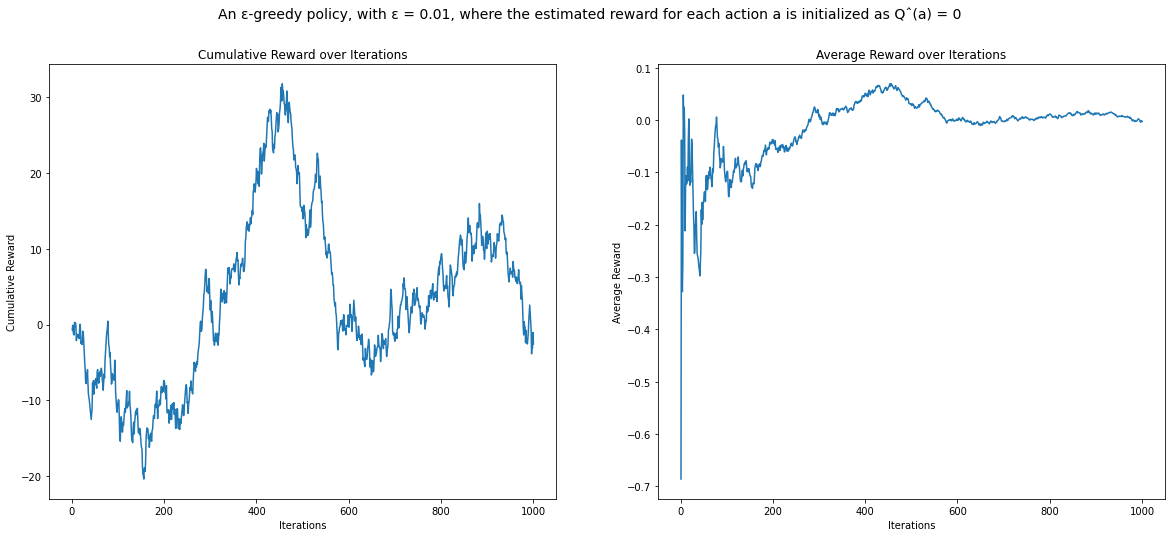

In [162]:
# Plot the Cumulative Reward and Average Reward

bandit_epsilon001_q0.plot_rewards('An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0')